In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-03-31 16:37:58.389984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 16:38:00.523585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-03-31 16:38:00.524650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=10,var1_u=60,CROP1=CROP,BATCH_SIZE=50,
                                               autoencoder=False)

2023-03-31 16:38:19.046183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:38:19.046446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:38:19.086786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:38:19.087066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-31 16:38:19.087293: I tensorflow/compiler/xla/stream_executo

In [3]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

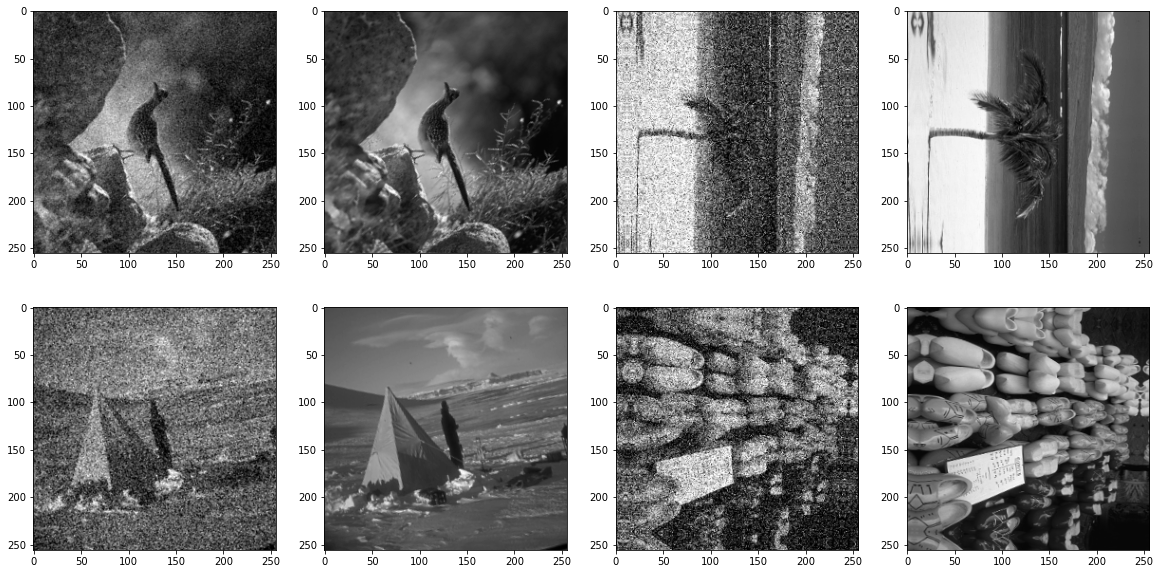

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

In [5]:
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return x


In [6]:
input_shape = image_size + (1,)
it_lim = 10
num_classes=10
order1 = 1
CROP=256
gamma=1

order = order1

inputs = tf.keras.Input(shape=input_shape,name='input')
x = classifier(inputs, num_classes=num_classes,CROP=CROP)

y = tf.keras.layers.Flatten(name='y')(x)

partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)

deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)


b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
a = tf.keras.layers.Reshape((num_classes,order))(a)

b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs

for num_it in range(it_lim):


    difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
    difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
    deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])

    dS_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaS)
    dE_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaE)

    dS2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2),name=f'dx_{num_it}')(dS_n)
    dE2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dE_n)

    ineq1_S = tf.greater_equal(dS2, partition_low)
    ineq2_S = tf.less_equal(dS2,partition_up)
    ineq1_E = tf.greater_equal(dE2, partition_low)
    ineq2_E = tf.less_equal(dE2,partition_up)

    interval_S = tf.cast(tf.math.logical_and(ineq1_S,ineq2_S),tf.float32)
    interval_E = tf.cast(tf.math.logical_and(ineq1_E,ineq2_E),tf.float32)

    power_norm_S = tf.pow(dS2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_S = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_S)
    cte_S = tf.ones_like(inputs)
    power_norm_S = tf.keras.layers.Concatenate(axis=-1)((cte_S,power_norm_S))
    power_norm_S = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_S)
    power_norm_E = tf.pow(dE2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_E = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_E)
    cte_E = tf.ones_like(inputs)
    power_norm_E = tf.keras.layers.Concatenate(axis=-1)((cte_E,power_norm_E))
    power_norm_E = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_E)


    spline_S = tf.keras.layers.multiply([ct,power_norm_S])
    spline_S = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_S)
    spline_S = tf.keras.layers.multiply([spline_S,interval_S])
    spline_E = tf.keras.layers.multiply([ct,power_norm_E])
    spline_E = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_E)
    spline_E = tf.keras.layers.multiply([spline_E,interval_E])


    gS = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gS_{num_it}')(spline_S)
    gS = tf.expand_dims(gS,axis=-1)
    gE = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gE_{num_it}')(spline_E)
    gE = tf.expand_dims(gE,axis=-1)

    E = tf.keras.layers.multiply((gE,deltaE))
    S = tf.keras.layers.multiply((gS,deltaS))

    NS = S
    EW = E
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
    EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

    mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))
    NS_mod = NS
    EW_mod = EW

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])



model =  tf.keras.models.Model(inputs, outputs)

In [194]:
inputs = xs
x = classifier(inputs, num_classes=num_classes,CROP=CROP)
y = tf.keras.layers.Flatten(name='y')(x)


b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)

a = tf.keras.layers.Reshape((num_classes,order))(a)

b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


s0 = tf.keras.layers.Dense(1,activation='sigmoid')(y)
minimum = tf.ones_like(a)/(num_classes)
fun = tf.keras.layers.multiply((minimum,a))
fun = tf.keras.layers.add((fun,b))
coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1)-1/num_classes)
coeffs = tf.keras.layers.multiply((coeffs,s0,a))
fun = tf.keras.layers.add((coeffs,fun))
minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(tf.squeeze(z),axis=-1))(fun)

#b = tf.keras.layers.add((b,minimum))

#################

b_initial2 = tf.keras.layers.Lambda(lambda z: z[:,-1])(fun)

a2 = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
a2 = tf.keras.layers.Reshape((num_classes,order))(a2)

b2 = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a2)
b2 = tf.pow(b2,np.arange(1,order+1))
b2 = tf.keras.layers.multiply([a2,b2])


m2 = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a2)+(0,0,num_classes-1))).to_dense()
b2 = tf.keras.layers.multiply([tf.transpose(b2,perm=(0,2,1)),m2])
b2 = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b2)
b02 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b2)
b2 = tf.keras.layers.Concatenate(axis=1)([b02,b2])
b2 = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b2)
b2 = tf.keras.layers.add((b2,b_initial2))
b2 = tf.expand_dims(b2,axis=-1)

maximum = tf.ones_like(a2)/num_classes
fun2 = tf.keras.layers.multiply((maximum,a2))
fun2 = tf.keras.layers.add((fun2,b2))
coeffs2 = tf.cumsum(tf.ones_like(a2)/(num_classes),axis=1) - 1/num_classes
s1 = tf.keras.layers.Lambda(lambda z: tf.ones_like(z)-z)(s0)
coeffs2 = tf.keras.layers.multiply((coeffs2,s1))
coeffs2 = tf.keras.layers.add((coeffs2,s0))
coeffs2 = tf.keras.layers.Lambda(lambda z: 2*z)(coeffs2)
fun2 = tf.keras.layers.add((fun2,coeffs2))
maximum = tf.keras.layers.Lambda(lambda z:-tf.reduce_max(tf.squeeze(z),axis=-1))(fun2)

b2 = tf.keras.layers.add((maximum,b2))

#################3

#a = tf.keras.layers.Concatenate(axis=1)((a,a2))
#b = tf.keras.layers.Concatenate(axis=1)((b,b2))


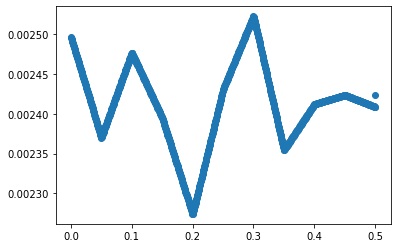

In [303]:
inputs = xs
x = classifier(inputs, num_classes=num_classes,CROP=CROP)
y = tf.keras.layers.Flatten(name='y')(x)


b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
a = tf.keras.layers.Reshape((num_classes,order))(a)
s0 = tf.keras.layers.Dense(1,activation='sigmoid')(y)

b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
b = tf.keras.layers.multiply((b,s0))
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


minimum = tf.ones_like(a)/(num_classes)
fun = tf.keras.layers.multiply((s0,minimum,a))
fun = tf.keras.layers.add((fun,b))
coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
coeffs = tf.keras.layers.multiply((coeffs,s0,a))
fun = tf.keras.layers.add((coeffs,fun))
minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(tf.squeeze(z),axis=-1))(fun)

b = tf.keras.layers.add((b,minimum))

_ = np.random.choice(len(xs))
A,B = a[_],b[_]

x = np.linspace(0,s0[_],100*num_classes)
y = np.copy(x)
y = np.reshape(y,(num_classes,100))
x = np.mod(x,s0[_]/(num_classes))
x = np.reshape(x,(num_classes,100))

function = (np.multiply(A,x) + B).numpy().flatten()
plt.scatter(y.flatten(),function)

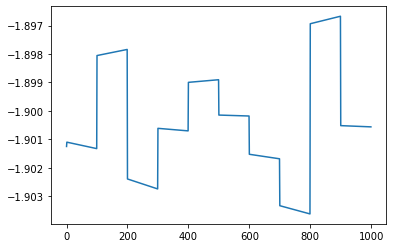

In [112]:
_ = np.random.choice(len(xs))
A,B = a2[_],b2[_]

x = np.linspace(s0[_],1,100*num_classes)
y = np.copy(x)
y = np.reshape(y,(num_classes,100))
x = np.mod(x,1/(num_classes))
x = np.reshape(x,(num_classes,100))

function = (np.multiply(A,x) + B).numpy().flatten()
plt.plot(function + 2*np.multiply(A,y).flatten())

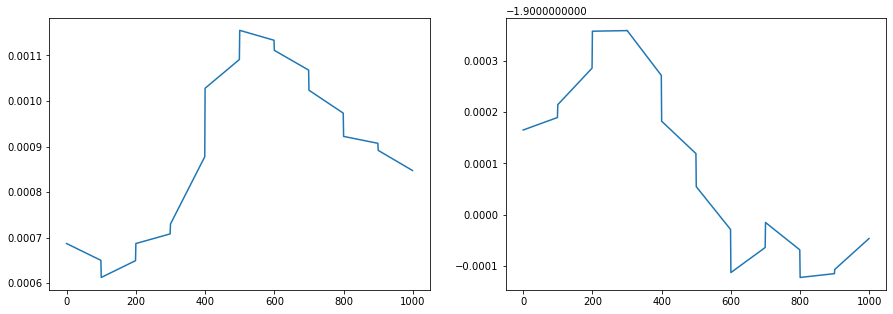

In [118]:
_ = np.random.choice(len(xs))
A,B = a[_],b[_]

x = np.linspace(0,1,2*100*num_classes)
y = np.copy(x)
y = np.reshape(y,(2*num_classes,100))
x = np.mod(x,1/(2*num_classes))
x = np.reshape(x,(2*num_classes,100))

#plt.plot((np.multiply(A,x) + B).numpy().flatten())
function = (np.multiply(A,x) + B).numpy().flatten()


plt.figure(figsize=(15,5))
plt.subplot(121)
#plt.plot((function + 2*np.multiply(A,y).flatten())[:1000])
plt.plot((function)[:1000])

plt.subplot(122)
plt.plot((function)[1000:])

In [568]:
b_initial[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.1994063e-06], dtype=float32)>

# Encoder

In [24]:
dim = 32*32
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    inputs = inputs
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(dim, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return tf.keras.Model(inputs,x)

input_shape = image_size + (1,)
embedding = classifier(tf.keras.layers.Input(input_shape))
embedding.load_weights('../border/checkpoints/embedding')

for layer in embedding.layers:
    layer.trainable = False

# Denoising

In [25]:
"""
Creating the model
"""
def conv_block(x, n_filt, size_conv=(5,5), n_conv=3):
    """
    Applies n_conv convolutions to the input with specified size and number of filters.
    """
    for c in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filt, size_conv, padding="same", activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def u_encoder(x, n_filt):
    """
    Applies conv_block and returnes max pooled and skip-connection.
    """
    x = conv_block(x, n_filt)
    return tf.keras.layers.MaxPool2D()(x), x

def u_decoder(pooled, skipped, n_filt):
    """
    Upsamples pooled and concats with skiped.
    """
    upsampled = tf.keras.layers.Convolution2DTranspose(n_filt, (2,2), strides=(2,2), padding='same')(pooled)
    return conv_block(tf.keras.layers.concatenate([upsampled, skipped]), n_filt)
    
    
def make_unet(inp, depth=3, output_channels=1):
    skipped = []
    p = inp
    for _ in range(depth):
        p, s = u_encoder(p, 2**(1+_))
        #p, s = u_encoder(p, 2*(1+_))
        skipped.append(s)
    p = conv_block(p, 2**(2+depth))
    for _ in reversed(range(depth)):
        p = u_decoder(p, skipped[_], 2**(2+_))  
        #p = u_decoder(p, skipped[_], (2**3)*(1+_))  
    p = tf.keras.layers.Conv2D(output_channels, (1,1), activation='sigmoid')(p)
    return p

def get_model(inp):
    """
    Takes network Input layer 
    """
    outp = make_unet(inp)
    return tf.keras.models.Model(inp, outp)

border = get_model(tf.keras.layers.Input(shape=(CROP,CROP, 1)))
border.load_weights(f"../border/checkpoints/borders_{typ}")

for layer in border.layers:
    layer.trainable = False

In [26]:
input_shape = image_size + (1,)
it_lim = 3
num_classes=10
order1 = 1
gamma=1
pre_smoothing=False
size=5
order = order1

inputs = tf.keras.Input(shape=input_shape,name='input')


#x = classifier(inputs, num_classes=num_classes,CROP=CROP)
x = embedding(inputs)

y = tf.keras.layers.Flatten(name='y')(x)

partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)

deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)


b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)

a = tf.keras.layers.Reshape((num_classes,order))(a)

b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = tf.keras.layers.Lambda(lambda z: tf.identity(z))(inputs)



for num_it in range(it_lim):


    difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
    difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    #deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
    #deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])
    deltaS = border(outputs)
    deltaE = border(outputs)

    dS_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaS)
    dE_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaE)

    dS2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2),name=f'dx_{num_it}')(dS_n)
    dE2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dE_n)

    ineq1_S = tf.greater_equal(dS2, partition_low)
    ineq2_S = tf.less_equal(dS2,partition_up)
    ineq1_E = tf.greater_equal(dE2, partition_low)
    ineq2_E = tf.less_equal(dE2,partition_up)

    interval_S = tf.cast(tf.math.logical_and(ineq1_S,ineq2_S),tf.float32)
    interval_E = tf.cast(tf.math.logical_and(ineq1_E,ineq2_E),tf.float32)

    power_norm_S = tf.pow(dS2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_S = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_S)
    cte_S = tf.ones_like(inputs)
    power_norm_S = tf.keras.layers.Concatenate(axis=-1)((cte_S,power_norm_S))
    power_norm_S = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_S)
    power_norm_E = tf.pow(dE2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_E = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_E)
    cte_E = tf.ones_like(inputs)
    power_norm_E = tf.keras.layers.Concatenate(axis=-1)((cte_E,power_norm_E))
    power_norm_E = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_E)


    spline_S = tf.keras.layers.multiply([ct,power_norm_S])
    spline_S = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_S)
    spline_S = tf.keras.layers.multiply([spline_S,interval_S])
    spline_E = tf.keras.layers.multiply([ct,power_norm_E])
    spline_E = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_E)
    spline_E = tf.keras.layers.multiply([spline_E,interval_E])


    gS = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gS_{num_it}')(spline_S)
    gS = tf.expand_dims(gS,axis=-1)
    gE = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gE_{num_it}')(spline_E)
    gE = tf.expand_dims(gE,axis=-1)

    difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
    difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
    deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
    deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])
    E = tf.keras.layers.multiply((gE,deltaE))
    S = tf.keras.layers.multiply((gS,deltaS))

    NS = S
    EW = E
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
    EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

    mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))
    NS_mod = NS
    EW_mod = EW

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])


        
model = tf.keras.models.Model(inputs, outputs)

In [27]:
def loss(y_true,y_pred):
    error = tf.reduce_mean(tf.pow(y_pred - y_true,2),axis=(1,2,3))
    return error

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/splinesborder_{typ}_{num_classes}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

In [28]:

history = model.fit(
        gen_batch_train,
        epochs=200,
        steps_per_epoch=50,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )

Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 0.0538
Epoch 1: val_loss improved from inf to 0.00958, saving model to ./checkpoints/splinesborder_gaussian_10
50/50 [==============================] - 36s 590ms/step - loss: 0.0538 - val_loss: 0.0096 - lr: 1.0000e-04
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 0.0084
Epoch 2: val_loss improved from 0.00958 to 0.00665, saving model to ./checkpoints/splinesborder_gaussian_10
50/50 [==============================] - 28s 563ms/step - loss: 0.0084 - val_loss: 0.0066 - lr: 1.0000e-04
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 0.0067
Epoch 3: val_loss improved from 0.00665 to 0.00619, saving model to ./checkpoints/splinesborder_gaussian_10
50/50 [==============================] - 28s 567ms/step - loss: 0.0067 - val_loss: 0.0062 - lr: 1.0000e-04
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 0.0059
Epoch 4: val_loss did not improve from 0.00619
50/50 [=

50/50 [==============================] - 26s 519ms/step - loss: 0.0037 - val_loss: 0.0034 - lr: 1.2800e-09
Epoch 65/200
50/50 [==============================] - ETA: 0s - loss: 0.0037
Epoch 65: val_loss did not improve from 0.00331
50/50 [==============================] - 26s 520ms/step - loss: 0.0037 - val_loss: 0.0034 - lr: 1.2800e-09
Epoch 66/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 66: val_loss did not improve from 0.00331
50/50 [==============================] - 26s 521ms/step - loss: 0.0036 - val_loss: 0.0034 - lr: 1.2800e-09
Epoch 67/200
50/50 [==============================] - ETA: 0s - loss: 0.0037
Epoch 67: val_loss did not improve from 0.00331

Epoch 67: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.
50/50 [==============================] - 26s 522ms/step - loss: 0.0037 - val_loss: 0.0035 - lr: 1.2800e-09
Epoch 68/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 68: val_loss did not improve from 0.0

50/50 [==============================] - 26s 522ms/step - loss: 0.0037 - val_loss: 0.0035 - lr: 8.1920e-14
Epoch 98/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 98: val_loss improved from 0.00331 to 0.00328, saving model to ./checkpoints/splinesborder_gaussian_10
50/50 [==============================] - 26s 528ms/step - loss: 0.0036 - val_loss: 0.0033 - lr: 1.6384e-14
Epoch 99/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 99: val_loss did not improve from 0.00328
50/50 [==============================] - 26s 520ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 1.6384e-14
Epoch 100/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 100: val_loss did not improve from 0.00328
50/50 [==============================] - 26s 523ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 1.6384e-14
Epoch 101/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 101: val_loss did not improve from 0.00328
50/50 [

50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 130: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 521ms/step - loss: 0.0036 - val_loss: 0.0034 - lr: 1.0486e-18
Epoch 131/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 131: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 1.0486e-18
Epoch 132/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 132: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0036 - lr: 1.0486e-18
Epoch 133/200
50/50 [==============================] - ETA: 0s - loss: 0.0037
Epoch 133: val_loss did not improve from 0.00326

Epoch 133: ReduceLROnPlateau reducing learning rate to 2.0971520409814568e-19.
50/50 [==============================] - 26s 520ms/step - loss: 0.0037 - val_loss: 0.0035 - lr: 1.0486e-1

Epoch 163/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 163: val_loss did not improve from 0.00326

Epoch 163: ReduceLROnPlateau reducing learning rate to 1.3421772842561475e-23.
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 6.7109e-23
Epoch 164/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 164: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 521ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 1.3422e-23
Epoch 165/200
50/50 [==============================] - ETA: 0s - loss: 0.0037
Epoch 165: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 521ms/step - loss: 0.0037 - val_loss: 0.0037 - lr: 1.3422e-23
Epoch 166/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 166: val_loss did not improve from 0.00326
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0035 -

50/50 [==============================] - 26s 519ms/step - loss: 0.0036 - val_loss: 0.0034 - lr: 8.5899e-28
Epoch 196/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 196: val_loss did not improve from 0.00321
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 8.5899e-28
Epoch 197/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 197: val_loss did not improve from 0.00321
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 8.5899e-28
Epoch 198/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 198: val_loss did not improve from 0.00321

Epoch 198: ReduceLROnPlateau reducing learning rate to 1.7179869031057572e-28.
50/50 [==============================] - 26s 522ms/step - loss: 0.0036 - val_loss: 0.0036 - lr: 8.5899e-28
Epoch 199/200
50/50 [==============================] - ETA: 0s - loss: 0.0036
Epoch 199: val_loss did not impro

In [33]:
xs, ys = next(gen_batch_val.as_numpy_iterator())
p = model(xs)

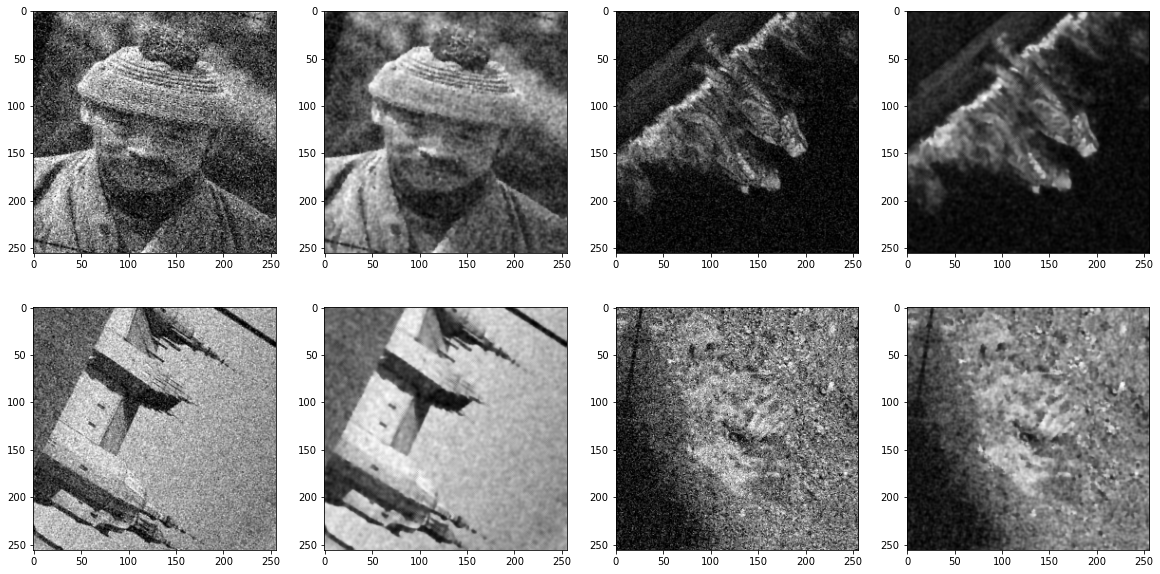

In [37]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(p[_]),cmap='gray')
        
plt.show()